In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [2]:
mpl.rcParams['agg.path.chunksize'] = 10000

## Считывание данных

In [3]:
df_txn = pd.read_csv("data\\txn.csv", sep=';')
df_sales = pd.read_csv("data\\sales.csv", sep=';')
df_prod = pd.read_csv('data\\art.csv', sep=';')

In [4]:
df_txn.head(3)

,DAY,STORE,ART,TXN,TIME,SALES
0,2015-11-05,22691,16548710,5877969776,17:23:57,"117,00000"
1,2015-10-24,20581,261204,5767364168,19:57:19,"140,17000"
2,2015-11-05,1574,16405210,5876151937,15:31:35,"26,90000"


In [5]:
# Изменение типов для столбцов SALES, DAY
df_txn['SALES'] = df_txn['SALES'].apply(lambda x: x.replace(',', '.')).astype(float)
df_txn['DAY'] = pd.to_datetime(df_txn['DAY'], format='%Y-%m-%d')

In [19]:
# Уникальные дни в данных
days = df_txn['DAY'].unique()
days.sort()

array(['2015-10-01T00:00:00.000000000', '2015-10-02T00:00:00.000000000',
       '2015-10-03T00:00:00.000000000', '2015-10-04T00:00:00.000000000',
       '2015-10-05T00:00:00.000000000'], dtype='datetime64[ns]')

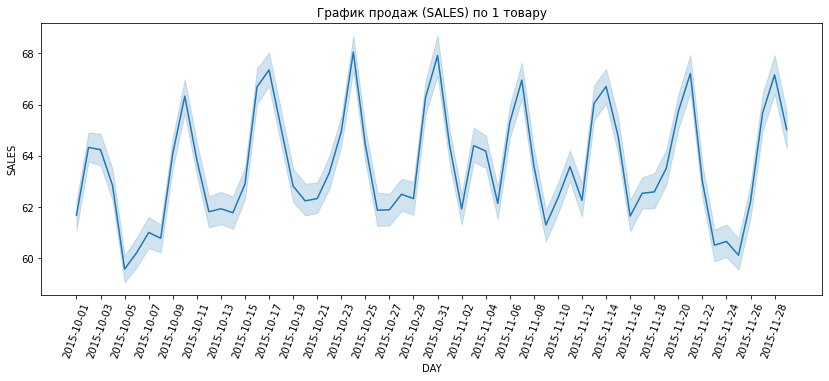

In [20]:
plt.figure(figsize=(14, 5))
sns.lineplot('DAY', 'SALES', data=df_txn)
plt.xticks([day for indx, day in enumerate(days) if indx%2 == 0], rotation=70)
plt.title("График продаж (SALES) по 1 товару") #
plt.show()

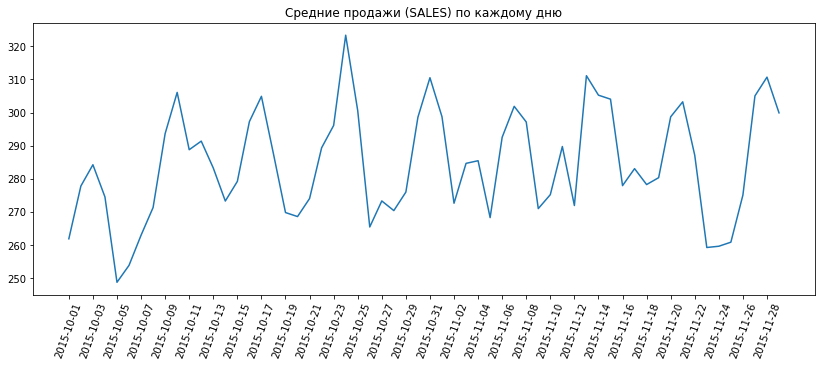

In [21]:
plt.figure(figsize=(14, 5))
day_mean_sales = df_txn.groupby(by=['DAY', 'TXN'])['SALES'].sum().groupby('DAY').mean()
plt.plot(day_mean_sales.index.values, day_mean_sales.values)
plt.xticks([day for indx, day in enumerate(day_mean_sales.index.values) if indx%2 == 0], rotation=70)
plt.title("Средние продажи (SALES) по каждому дню") #
plt.show()
# Из графика можно заметить, что существует периодичность "сезонность" ~= каждые 5 дней

In [22]:
df_txn = df_txn.sort_values(by=['DAY'])

<b>Рассчитать основные показатели:</b> 
1. Средний чек магазина
2. ср. кол-во чеков на 1 магазин. в день
3. ср. продажи на 1 магазин. в день (детализация до товара/группы не нужна).

## Формирование данных для предсказывания

#### Средний чек магазина по каждому дню

In [28]:
# Сумма каждого чека по магазинам
store_day_txn_sales = df_txn.groupby(by=['STORE', 'DAY', 'TXN'])['SALES'].sum()

In [29]:
# Средняя сумма по чекам
store_day_mean_txn = store_day_txn_sales.groupby(by=['STORE', 'DAY']).mean()
store_day_mean_txn.head(3)

STORE  DAY       
956    2015-10-01    228.584189
       2015-10-02    247.682926
       2015-10-03    232.513370
Name: SALES, dtype: float64

In [30]:
# Преобразование в таблицу
store_day_mean_txn = store_day_mean_txn.unstack(0).sort_index()
store_day_mean_txn.head(3)

STORE,956,958,961,974,980,999,1053,1082,1094,1122,...,17096,17474,19009,20581,21761,22691,24605,25039,27220,29245
DAY,,,,,,,,,,,,,,,,,,,,,
2015-10-01,228.584189,277.854557,331.063739,248.127198,264.572985,316.792187,248.345995,233.880785,266.421166,245.560327,...,246.038221,302.533732,219.294244,293.958554,240.743825,260.388124,240.253297,279.007516,292.614620,252.594192
2015-10-02,247.682926,285.929766,320.212698,251.682180,277.266675,350.831708,240.322689,247.945911,292.355551,283.620529,...,265.010130,321.513619,251.166528,262.991259,262.839413,285.989461,248.305928,283.711109,312.345174,295.587849
2015-10-03,232.513370,316.983611,322.072317,292.019290,260.913369,321.921526,253.234638,231.767804,312.002931,266.279708,...,265.880532,334.151068,253.717112,316.150830,279.722187,277.075860,261.254290,299.901229,324.559240,261.805465


#### Количесво уникальных чеков на каждый день для магазинов

In [31]:
# Количесво уникальных чеков на каждый день для магазинов
store_date_count_txn = df_txn.groupby(by=['STORE', 'DAY', ])['TXN'].nunique()

In [32]:
store_date_count_txn = store_date_count_txn.unstack(0).sort_index()
store_date_count_txn.head(3)

STORE,956,958,961,974,980,999,1053,1082,1094,1122,...,17096,17474,19009,20581,21761,22691,24605,25039,27220,29245
DAY,,,,,,,,,,,,,,,,,,,,,
2015-10-01,541,503,474,324,257,667,497,769,780,392,...,773,974,734,403,896,565,433,655,448,329
2015-10-02,615,541,500,298,253,652,517,813,770,400,...,735,946,691,432,795,576,402,635,442,370
2015-10-03,600,444,406,218,281,506,436,815,643,393,...,648,997,665,344,740,523,386,513,492,335


#### Средние продажи на 1 магазин. в день

In [35]:
# Cумма продаж в каждом магазине по дням
store_day_mean_sales = df_txn.groupby(by=['STORE', 'DAY'])['SALES'].sum()
store_day_mean_sales.head()

STORE  DAY       
956    2015-10-01    123664.0461
       2015-10-02    152324.9996
       2015-10-03    139508.0220
       2015-10-04    133517.2429
       2015-10-05    124487.8700
Name: SALES, dtype: float64

In [36]:
store_day_mean_sales = store_day_mean_sales.unstack(0).sort_index()
store_day_mean_sales.head(3)

STORE,956,958,961,974,980,999,1053,1082,1094,1122,...,17096,17474,19009,20581,21761,22691,24605,25039,27220,29245
DAY,,,,,,,,,,,,,,,,,,,,,
2015-10-01,123664.0461,139760.8423,156924.2125,80393.2123,67995.2571,211300.3889,123427.9594,179854.3240,207808.5093,96259.6480,...,190187.5445,294667.8552,160961.9751,118465.2974,215706.4673,147119.2898,104029.6774,182749.9232,131091.3497,83103.4892
2015-10-02,152324.9996,154688.0035,160106.3490,75001.2897,70148.4687,228742.2739,124246.8303,201580.0259,225113.7741,113448.2117,...,194782.4459,304151.8835,173556.0707,113612.2237,208957.3335,164729.9296,99818.9830,180156.5544,138056.5669,109367.5041
2015-10-03,139508.0220,140740.7234,130761.3606,63660.2053,73316.6568,162892.2920,110410.3021,188890.7599,200617.8849,104647.9251,...,172290.5847,333148.6149,168721.8792,108755.8854,206994.4185,144910.6746,100844.1561,153849.3307,159683.1462,87704.8308


## Предсказывание данных

In [37]:
import warnings
warnings.filterwarnings('ignore')

2.1 Средний чек магазина по каждому дню

In [40]:
def last_day_predictions(df_with_store_cols):
    """Learns SARIMAX (Seasonal AutoRegressive Integrated Moving Average) models
        to get result of predictions for next - 'last day'
    params:
        df_with_store_cols : dataframe with columns like shop_id and rows like datetime
    returns:
        results (list): list with results of predictions for each model
    """
    results = []
    # Создаем модель для каждого магазина и передаем данные на существующий период
    
    for shop_id in store_day_mean_txn.columns:
        # обучаем на текущем временном ряду 
        store_model = sm.tsa.statespace.SARIMAX(df_with_store_cols[shop_id][1:], freq='D', enforce_stationarity=False, enforce_invertibility=False).fit()
        # предсказываем на след день. (без проверки точности и валидации т.к. интересует 1 день + множество моделей)
        store_res = store_model.predict(df_with_store_cols.shape[0]-1)[0]
        results.append(store_res) # добавляем результат
    return results

In [43]:
store_mean_txn_last_day = last_day_predictions(store_day_mean_txn)
print("Результаты - ожидаемая средняя сумма по чеку на 2015-11-30")
for store_id, store_res in zip(store_day_mean_txn.columns.values, np.array(store_mean_txn_last_day)):
    print(f"Магазин {store_id:>5} - {store_res:.5}")
print(f'Средняя сумма по всем магазинам: {np.array(store_mean_txn_last_day).mean():.5}')
# last_day_txn_sales = pd.DataFrame({"STORE": store_day_mean_txn.columns.values, "MEAN_TXN_SALES": np.array(store_mean_txn_last_day, dtype=int)})
# last_day_txn_sales

Результаты - ожидаемая средняя сумма по чеку на 2015-11-30
Магазин   956 - 251.7
Магазин   958 - 302.5
Магазин   961 - 343.27
Магазин   974 - 281.18
Магазин   980 - 270.88
Магазин   999 - 331.15
Магазин  1053 - 253.63
Магазин  1082 - 241.42
Магазин  1094 - 328.09
Магазин  1122 - 288.67
Магазин  1530 - 247.97
Магазин  1534 - 347.91
Магазин  1544 - 347.98
Магазин  1574 - 197.85
Магазин  1579 - 331.32
Магазин  1594 - 309.16
Магазин  1596 - 332.29
Магазин  1602 - 225.98
Магазин  1609 - 306.53
Магазин  1612 - 281.01
Магазин 17096 - 284.07
Магазин 17474 - 332.96
Магазин 19009 - 265.13
Магазин 20581 - 305.65
Магазин 21761 - 275.49
Магазин 22691 - 287.99
Магазин 24605 - 297.51
Магазин 25039 - 380.82
Магазин 27220 - 388.62
Магазин 29245 - 270.89
Средняя сумма по всем магазинам: 296.99


2.2 Количество чеков по магазинам

In [45]:
store_count_txns_last_day = last_day_predictions(store_date_count_txn)
print("Результаты - ожидаемое кол-во чеков на 2015-11-30")
for store_id, store_res in zip(store_date_count_txn.columns.values, np.array(store_count_txns_last_day, dtype=int)):
    print(f"Магазин {store_id:>5} - {store_res:<4} чеков")

print(f'Среднее кол-во чеков по всем магазинам: {int(np.array(store_count_txns_last_day).mean())}')
# last_day_txns_count = pd.DataFrame({"STORE": store_date_count_txn.columns.values, "TXNS_COUNT": np.array(store_count_txns_last_day, dtype=int)})
# last_day_txns_count

Результаты - ожидаемое кол-во чеков на 2015-11-30
Магазин   956 - 522  чеков
Магазин   958 - 476  чеков
Магазин   961 - 406  чеков
Магазин   974 - 208  чеков
Магазин   980 - 184  чеков
Магазин   999 - 568  чеков
Магазин  1053 - 441  чеков
Магазин  1082 - 676  чеков
Магазин  1094 - 563  чеков
Магазин  1122 - 388  чеков
Магазин  1530 - 189  чеков
Магазин  1534 - 540  чеков
Магазин  1544 - 361  чеков
Магазин  1574 - 355  чеков
Магазин  1579 - 628  чеков
Магазин  1594 - 470  чеков
Магазин  1596 - 403  чеков
Магазин  1602 - 363  чеков
Магазин  1609 - 493  чеков
Магазин  1612 - 566  чеков
Магазин 17096 - 665  чеков
Магазин 17474 - 969  чеков
Магазин 19009 - 600  чеков
Магазин 20581 - 273  чеков
Магазин 21761 - 755  чеков
Магазин 22691 - 575  чеков
Магазин 24605 - 351  чеков
Магазин 25039 - 431  чеков
Магазин 27220 - 411  чеков
Магазин 29245 - 393  чеков
Среднее кол-во чеков по всем магазинам: 474


2.3 Средние продажи на 1 магазин. в день

In [49]:
store_mean_sales_last_day = last_day_predictions(store_day_mean_sales)
print("Результаты - ожидаемые средние продажи на 2015-11-30")
for store_id, store_res in zip(store_day_mean_sales.columns.values, np.array(store_mean_sales_last_day, dtype=float)):
    print(f"Магазин {store_id:>5} - {store_res:.10}")

print(f'Ожидаемые средние продажи: {np.array(store_mean_sales_last_day).mean():.10}')
# last_day_mean_sales = pd.DataFrame({"STORE": store_day_mean_sales.columns.values, "MEAN_SALES": np.array(store_day_mean_sales, dtype=int)})
# last_day_mean_sales

Результаты - ожидаемые средние продажи на 2015-11-30
Магазин   956 - 131552.322
Магазин   958 - 144356.9379
Магазин   961 - 139747.2807
Магазин   974 - 59097.49085
Магазин   980 - 50075.31838
Магазин   999 - 188563.067
Магазин  1053 - 112066.1999
Магазин  1082 - 163232.3693
Магазин  1094 - 185875.9259
Магазин  1122 - 112238.855
Магазин  1530 - 46953.25626
Магазин  1534 - 187663.7217
Магазин  1544 - 126505.3761
Магазин  1574 - 71061.73444
Магазин  1579 - 208070.6934
Магазин  1594 - 145875.4624
Магазин  1596 - 134472.4492
Магазин  1602 - 82347.59387
Магазин  1609 - 151558.1155
Магазин  1612 - 159371.395
Магазин 17096 - 189445.045
Магазин 17474 - 322709.4468
Магазин 19009 - 159604.2691
Магазин 20581 - 84074.85826
Магазин 21761 - 208574.9197
Магазин 22691 - 166045.4318
Магазин 24605 - 105076.638
Магазин 25039 - 165280.7918
Магазин 27220 - 160279.5227
Магазин 29245 - 106486.566
Ожидаемые средние продажи: 142275.4351
